# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import sys 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from utils import print_evaluation_metrics, print_memory_usage, clean_database, \
    create_dataloaders, train_and_evaluate_pytorch_model, \
    analyze_correlations, perform_voting_feature_selection, log_metrics, plot_individual_metrics
from preprocess import preprocessing
pd.set_option('display.max_columns', None)

preprocessing_dir = os.path.join('figures','preprocessing')
results_dir = os.path.join('figures', 'results')
evaluation_dir = os.path.join('figures','evaluatoin charts')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)

[Dataset Info] Attack Type Distribution (Counts):
Attack Type
Benign            477716
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attac

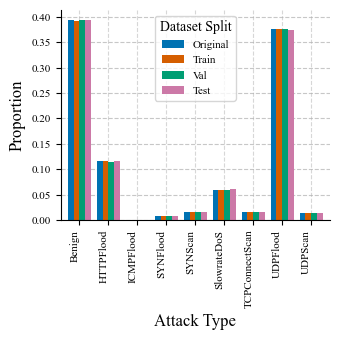

[Memory] Before GC: 1449.58 MB
[Memory] After GC: 1288.58 MB
[Preprocessing] Applying standard scaling...
<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=True, fix_skewness=False)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

In [3]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

Remaining features count: 40
Remaining features list:
['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']


# Arguments

In [4]:
version = "30F"
sampling_method = 'smote'
plot_distributions = True

<h1 style="color:red;">Compare the results of all methods</h1>

In [5]:
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=30, 
    sample_size=None, 
    top_k=3,
    file_path= preprocessing_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")


[Comparison] Using full training data (972695 samples) for feature selection.

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 30 features...
[Filter] Completed in 0.13 seconds.
[Filter] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'State', 'SrcWin', 'TcpRtt', 'AckDat']
Iteration 1, loss = 0.12935440
Validation score: 0.965231
Iteration 2, loss = 0.06911608
Validation score: 0.963473
Iteration 3, loss = 0.06187778
Validation score: 0.972643
Iteration 4, loss = 0.05884076
Validation score: 0.973044
Iteration 5, loss = 0.05680106
Validation score: 0.972067
Iteration 6, loss = 0.05538464
Validation score: 0.968449
Iteration 7, loss = 0.05374620
Validation score: 0.972273
Iteration 8, loss = 

KeyboardInterrupt: 

## Filter the dataframes to include only selected columns

In [ ]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# Preprocessing

In [ ]:
X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val_processed, y_test_processed = preprocessing(X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_dir, version, sampling_method, plot_distributions)
print_memory_usage("Notebook - Ready for Training")

# Save the dataframes in directory

In [ ]:
# 1. Define the directory to save the processed data
# You can adjust the path name as needed
save_dir = os.path.join('data frames', 'main','30 features')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

print(f"Saving data to: {os.path.abspath(save_dir)}")

# 2. Save the feature matrices (X)
# These are already numpy arrays (float32) from your preprocessing function
np.save(os.path.join(save_dir, 'X_train_processed.npy'), X_train_processed)
np.save(os.path.join(save_dir, 'X_val_scaled.npy'), X_val_processed)
np.save(os.path.join(save_dir, 'X_test_scaled.npy'), X_test_processed)

# 3. Save the target vectors (y)
np.save(os.path.join(save_dir, 'y_resampled.npy'), y_train_processed)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val_processed)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test_processed)

# 4. Save the label encoder classes
# This is crucial if you want to map predictions back to original names (e.g., 'Benign', 'DDoS') later
np.save(os.path.join(save_dir, 'label_classes.npy'), output_encoder.classes_)

print("All datasets saved successfully.")

Created directory: ../data frames/DL/15 Features
Saving data to: /Users/hemaali/Desktop/Master Degree Project/data frames/DL/15 Features
All datasets saved successfully.
